In [0]:
#from __future__ import division #TODO - what is that?
import os, time ,scipy.io
import numpy as np
import pandas as pd
!pip install rawpy
import rawpy
#import glob
import h5py
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive/')

    100% |████████████████████████████████| 686kB 14.8MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
def sample_list_from_file(file_path):
  train_samples = pd.read_csv(file_path, sep=" ", header=None) 
  train_samples.columns = ['input', 'gt', 'dont_care', 'dont_care']
  train_samples = train_samples.loc[train_samples['input'].str.contains('_00_', regex=False)]
  train_samples = train_samples.reset_index(drop=True)
  return train_samples

def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level and normalize to [0,1]
    #im = im/(16383)  # keeping the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    return out

In [0]:
#delete images of sequence
# file_path = TRAIN_SAMPLES_FILE
# total = pd.read_csv(file_path, sep=" ", header=None)
# total.columns = ['input', 'gt', 'dont_care', 'dont_care']
# to_delete = total.loc[total['input'].str.contains('_0[1-9]_', regex=True)] #TODO - didn't delte seq with 10 and above.
# to_delete = to_delete.reset_index(drop=True)
# print(len(total))
# print(len(to_delete))

# for n in range(len(to_delete)):
#   path1 = DATASET_PATH + to_delete['input'][n]
#   if os.path.isfile(path1):
#     os.remove(path1)

In [0]:
PATH              = "./drive/Team Drives/final_project_302676838/"
DATASET_PATH      = PATH + 'dataset/'
DB_FILE_TRAIN     = DATASET_PATH + 'db_train_compressed2.hdf5'
DB_FILE_VAL       = DATASET_PATH + 'db_val_compressed_tmp.hdf5'
DB_FILE_TEST      = DATASET_PATH + 'db_test_compressed_tmp.hdf5'
# DB_FILE_IN           = DATASET_PATH + 'db_in.hdf5'
# DB_FILE_GT           = DATASET_PATH + 'db_gt.hdf5'

TRAIN_SAMPLES_FILE = DATASET_PATH + 'Sony_train_list.txt' #(0) - 280
VALIDATION_SAMPLES_FILE  = DATASET_PATH + 'Sony_val_list.txt'#(2) - 36
TEST_SAMPLES_FILE  = DATASET_PATH + 'Sony_test_list.txt' #(1) - 93

train_samples      = sample_list_from_file(TRAIN_SAMPLES_FILE)
validation_samples = sample_list_from_file(VALIDATION_SAMPLES_FILE)
test_samples       = sample_list_from_file(TEST_SAMPLES_FILE)

N_TRAIN      = len(train_samples.index)
N_VALIDATION = len(validation_samples.index)
N_TEST       = len(test_samples.index)

WIDTH = 4256
HEIGHT = 2848

PATCH_SIZE = 512

,input,gt,dont_care,dont_care
0,./Sony/short/20005_00_0.04s.ARW,./Sony/long/20005_00_10s.ARW,ISO200,F13
1,./Sony/short/20005_00_0.1s.ARW,./Sony/long/20005_00_10s.ARW,ISO200,F13
2,./Sony/short/20007_00_0.04s.ARW,./Sony/long/20007_00_10s.ARW,ISO320,F4.5
3,./Sony/short/20007_00_0.1s.ARW,./Sony/long/20007_00_10s.ARW,ISO320,F4.5
4,./Sony/short/20008_00_0.04s.ARW,./Sony/long/20008_00_10s.ARW,ISO500,F4.5
5,./Sony/short/20008_00_0.1s.ARW,./Sony/long/20008_00_10s.ARW,ISO500,F4.5
6,./Sony/short/20020_00_0.04s.ARW,./Sony/long/20020_00_10s.ARW,ISO320,F8
7,./Sony/short/20020_00_0.1s.ARW,./Sony/long/20020_00_10s.ARW,ISO320,F8
8,./Sony/short/20025_00_0.04s.ARW,./Sony/long/20025_00_10s.ARW,ISO320,F9
9,./Sony/short/20025_00_0.1s.ARW,./Sony/long/20025_00_10s.ARW,ISO320,F9


In [0]:
with h5py.File(DB_FILE_TRAIN, 'w') as f: #change to train/val/test #debug
  train_group = f.create_group("train") #change to train/val/test
  in_group = train_group.create_group('in')
  gt_group = train_group.create_group('gt')

  for n in range(N_TRAIN): #change to train/val/test #debug, n=1
    print(str(n)) 
    in_base_name = train_samples['input'][n] #change to train/val/test
    in_exposure = float(in_base_name[22:-5])

    gt_base_name = train_samples['gt'][n] #change to train/val/test
    gt_exposure = float(gt_base_name[21:-5])

    img_id = int(in_base_name[14:18])
    exposure_ratio = int(min(gt_exposure / in_exposure, 300))

    in_raw = rawpy.imread(DATASET_PATH + in_base_name )
    in_raw = np.expand_dims(pack_raw(in_raw), axis=0) * exposure_ratio

    #in_dset = in_group.create_dataset('sample_' + str(n), data=in_raw)
    in_dset  = in_group.create_dataset('sample_' + str(n), data=in_raw, chunks=(1, PATCH_SIZE, PATCH_SIZE, 4), compression='gzip', compression_opts=9)
    in_dset.attrs['ID']             = img_id
    in_dset.attrs['in_exposure']    = in_exposure
    #in_dset.attrs['gt_exposure']    = int(gt_exposure) #todo - tmp until I will write down the gt in hdf5 
    in_dset.attrs['exposure_ratio'] = exposure_ratio

    if str(img_id) in gt_group: #skip if already exists in ground_truth file
      continue

    gt_raw = rawpy.imread(DATASET_PATH + gt_base_name)
    gt_processed = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16) #TODO - read from google drive
    gt_processed = np.expand_dims(np.float32(gt_processed / pow(2,16)), axis=0)

    #gt_dset = gt_group.create_dataset( str(img_id), data=gt_processed)
    gt_dset = gt_group.create_dataset( str(img_id), data=gt_processed , chunks=(1, PATCH_SIZE*2, PATCH_SIZE*2, 3), compression='gzip', compression_opts=9)
    gt_dset.attrs['gt_exposure']    = gt_exposure

In [0]:
#generate trational pipeling images
for n in range(N_VALIDATION): #change to train/val/test #debug, n=1
  print(str(n)) 
  in_base_name = validation_samples['input'][n] #change to train/val/test
  gt_base_name = validation_samples['gt'][n]
  raw = rawpy.imread(DATASET_PATH + in_base_name )
  im = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
  scale_full = np.expand_dims(np.float32(im / 65535.0), axis=0)
  
  gt_raw = rawpy.imread(DATASET_PATH + gt_base_name)
  im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
  gt_full = np.expand_dims(np.float32(im / 65535.0), axis=0)
        
  gt_full = gt_full[0, :, :, :]
  scale_full = scale_full[0, :, :, :]
  scale_full = scale_full * np.mean(gt_full) / np.mean(scale_full)      

  scipy.misc.toimage(scale_full * 255, high=255, low=0, cmin=0, cmax=255).save(DATASET_PATH + 'Sony/short_processed' + '/%d_short_ISP.png' % (n))



0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


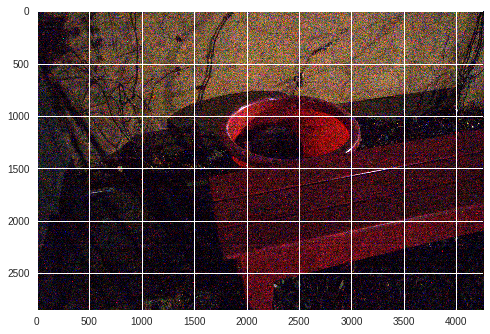

In [0]:
scale_full.max()
plt.imshow(scale_full)
n=5;

In [0]:
# DB_FILE = DATASET_PATH + 'db_no_comp.hdf5'
# f_no_comp = h5py.File(DB_FILE, 'r')

# DB_FILE = DATASET_PATH + 'db_comp.hdf5'
# f_comp = h5py.File(DB_FILE, 'r')

# f = f_comp
# t1_time = time.time()
# f['train/in/sample_' + str(n)].shape
# img_id = f['train/in/sample_' + str(n)].attrs['ID']
# gt_exposure = f['train/in/sample_' + str(n)].attrs['gt_exposure']

# xx = np.random.randint(0, WIDTH - PATCH_SIZE) # crop PATCH_SIZE
# yy = np.random.randint(0, HEIGHT - PATCH_SIZE)
# in_patch = f['train/in/sample_' + str(n)][:, yy:yy + PATCH_SIZE, xx:xx + PATCH_SIZE, :]
# print(time.time()-t1_time)

# f = f_no_comp
# t1_time = time.time()
# f['train/in/sample_' + str(n)].shape
# img_id = f['train/in/sample_' + str(n)].attrs['ID']
# gt_exposure = f['train/in/sample_' + str(n)].attrs['gt_exposure']

# xx = np.random.randint(0, WIDTH - PATCH_SIZE) # crop PATCH_SIZE
# yy = np.random.randint(0, HEIGHT - PATCH_SIZE)
# in_patch = f['train/in/sample_' + str(n)][:, yy:yy + PATCH_SIZE, xx:xx + PATCH_SIZE, :]
# print(time.time()-t1_time)